## Packages and Assets

In [9]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


## Dependencies

In [10]:
test_pp = pd.read_csv('../../assets/data/splits/test/preprocessed.csv')
test_pp

,title,tags,url,time,label
0,petrobras confirma ajuste politica preco reite...,"['Empresas', 'Governo Federal', 'Petrobras', '...",https://www.moneytimes.com.br/petrobras-confir...,19:31:00,0
1,apenas sulamerica yduqs permanecem carteira xp...,"['Ações', 'B3', 'Banrisul', 'BR Malls', 'Carte...",https://www.moneytimes.com.br/apenas-sulameric...,07:50:00,1
2,unigel compra gas natural petrobras shell fabr...,"['Bahia', 'Empresas', 'Fertilizantes', 'Petrob...",https://www.moneytimes.com.br/unigel-compra-ga...,19:26:00,0
3,petrobras abre processo vender <NUM> cento par...,"['Combustíveis', 'Commodities', 'Empresas', 'P...",https://www.moneytimes.com.br/petrobras-abre-p...,08:46:00,1
4,um maiores eventos monitorar acoes petrobras c...,"['Ações', 'Combustíveis', 'Comprar ou vender?'...",https://www.moneytimes.com.br/um-dos-maiores-e...,15:27:00,0
...,...,...,...,...,...
304,petrobras petr4 deve anunciar producao petrole...,"['ANP', 'Petrobras (PETR4)', 'Petróleo']",https://www.suno.com.br/noticias/petrobras-pet...,14:34:00,0
305,ibovespa fecha abaixo <NUM> mil pontos <NUM> v...,"['Bradesco', 'Coronavírus', 'CSN', 'Gerdau', '...",https://www.moneytimes.com.br/ibovespa-fecha-a...,17:17:00,0
306,ibovespa fecha alta <NUM> cento ultrapassa <NU...,"['Gol Linhas Aéreas (GOLL11/GOLL4)', 'Ibovespa...",https://www.suno.com.br/noticias/ibovespa-fech...,18:31:00,0
307,petrobras mira nova emissao mercado internacio...,"['Ações', 'Commodities', 'Empresas', 'Petrobra...",https://www.moneytimes.com.br/petrobras-mira-n...,10:00:00,1


In [11]:
model = keras.models.load_model('../../assets/deep_assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9, 300)            1112700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 9, 32)            40576     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 9, 32)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [12]:
# Load the tokenizer from the file
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Predictions considering best deep model

In [13]:
X_test = test_pp.title
y_test = test_pp.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=8, padding='post', truncating='post')
test_padded

array([[   2,  175, 1079, ..., 3645,    0,    0],
       [ 909,    1, 1237, ...,  137,   35,  614],
       [ 741,  120,   19, ...,  840,  593,    0],
       ...,
       [   4,   10,    8, ...,    3,   26,   22],
       [   2,  273,   37, ...,  134,   64,  280],
       [  28,   42, 2755, ...,  116,    3,    9]])

### Functions

In [14]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [15]:
index_word = index2word(word_index)

In [16]:
pred_prob = model.predict(test_padded)

10/10 [==============================] - 1s 3ms/step


In [17]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [18]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[2, 175, 1079, 58, 23, 844, 3645]",petrobras confirma ajuste politica preco reite...,"[petrobras, confirma, ajuste, politica, preco,...",0,0
1,"[909, 1, 1237, 1, 17, 131, 137, 35, 614]",apenas sulamerica yduqs permanecem carteira xp...,"[apenas, <OOV>, yduqs, <OOV>, carteira, xp, ja...",0,1
2,"[741, 120, 19, 208, 2, 521, 840, 593]",unigel compra gas natural petrobras shell fabr...,"[unigel, compra, gas, natural, petrobras, shel...",0,0
3,"[2, 84, 107, 132, 3, 6, 146, 52, 749, 73]",petrobras abre processo vender <NUM> cento par...,"[petrobras, abre, processo, vender, num, cento...",0,1
4,"[1430, 274, 1, 1, 9, 2, 1, 448, 361]",um maiores eventos monitorar acoes petrobras c...,"[um, maiores, <OOV>, <OOV>, acoes, petrobras, ...",0,0
...,...,...,...,...,...
304,"[2, 5, 63, 1743, 40, 13, 3, 6, 79, 3, 223, 7, 65]",petrobras petr4 deve anunciar producao petrole...,"[petrobras, petr4, deve, anunciar, producao, p...",0,0
305,"[4, 10, 270, 3, 26, 22, 3, 785, 111, 324]",ibovespa fecha abaixo <NUM> mil pontos <NUM> v...,"[ibovespa, fecha, abaixo, num, mil, pontos, nu...",0,0
306,"[4, 10, 8, 3, 6, 753, 3, 26, 22]",ibovespa fecha alta <NUM> cento ultrapassa <NU...,"[ibovespa, fecha, alta, num, cento, ultrapassa...",0,0
307,"[2, 273, 37, 465, 41, 880, 134, 64, 280]",petrobras mira nova emissao mercado internacio...,"[petrobras, mira, nova, emissao, mercado, inte...",0,1


### Metrics

In [19]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       173
           1       1.00      0.01      0.03       136

    accuracy                           0.57       309
   macro avg       0.78      0.51      0.37       309
weighted avg       0.76      0.57      0.42       309

Confusion Matrix


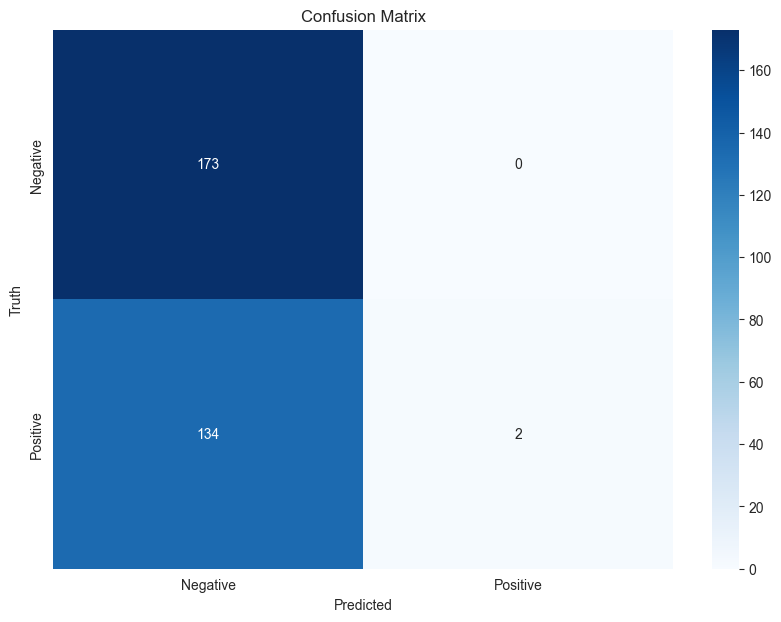

In [20]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)